# Austin, TX Crime Analysis

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from census import Census
import gmaps
import requests
import json

# usefuls.py
from usefuls import atx_zip_codes, zipcode_tabulation_area, similar_offense_type

# config.py not included on GitHub for obvious reasons
from config import gkey, census_key

# Configure gmaps
gmaps.configure(api_key=gkey)

## Get and clean data

### Get Property Data from Zillow
* The data file is too large to upload to GitHub, but it is obtainable from [here](https://www.kaggle.com/zillow/zecon#Zip_time_series.cs)

In [2]:
# Read the file
zillow_df = pd.read_csv('Zip_time_series.csv')

# Rename RegionName to zipcode
zillow_df = zillow_df.rename(columns={'RegionName': 'Zip Code'})

# Filter out all non-Austin area zipcodes
zillow_df = zillow_df[[(z in atx_zip_codes) for z in zillow_df['Zip Code']]]

# Add year column to dataframe
zillow_df['year'] = zillow_df['Date'].apply(lambda s : int(s[:4]))

# Filter out all years before 2009
zillow_df = zillow_df[(zillow_df['year'] >= 2011) & (zillow_df['year'] <= 2016)]

# Keep only the columns we need
zillow_df = zillow_df[['year', 'Zip Code', 'ZHVI_AllHomes']]

# Drop NaN values
zillow_df = zillow_df.dropna()

# Group data by year, zipcode, find the mean ZHVI per year per zipcode
zillow_df = round(zillow_df.groupby(['year', 'Zip Code']).ZHVI_AllHomes.mean(),2).to_frame()

# Write to csv
zillow_df.to_csv('zillow_data.csv')

# Preview the frame
zillow_df.head()

ZHVI_AllHomes
year Zip Code               
2011 78610         167591.67
     78613         182450.00
     78617         104841.67
     78641         143600.00
     78664         130350.00

### Get Austin Police Department crime data
* The csv file used is obtainable from [here](https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu)

In [3]:
crime_df = pd.read_csv('Crime_Reports.csv')

# Filter out non greater Austin zip codes
crime_df = crime_df[crime_df['Zip Code'].isin(atx_zip_codes)]

# Extract only years from date
crime_df['year'] = crime_df['Occurred Date'].apply(lambda d : int(d[-4:]))

# Drop unnecessary columns
crime_df = crime_df[['Zip Code', 'year', 'Highest Offense Description']]

# Convert zip codes to integer type
crime_df['Zip Code'] = crime_df['Zip Code'].apply(lambda x: int(x))

# Combine similar offenses
crime_df["Highest Offense Description"] = crime_df["Highest Offense Description"].replace(similar_offense_type)

# For year 2018
crime2018_df = crime_df[crime_df['year'] == 2018]

# Write to csv
crime2018_df.to_csv('crime_types_2018.csv', index=False)

# Look at only years 2011-2016
crime_df = crime_df[(crime_df['year'] >= 2011) & (crime_df['year'] <= 2016)]

# Write to csv
crime_df.to_csv('crime_data.csv', index=False)

# Preview
crime_df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Zip Code,year,Highest Offense Description
1,78701,2014,Burglary
2,78702,2015,Other
5,78759,2015,Motor Vehicle Theft
6,78741,2013,Burglary
8,78719,2016,Other


### Get census data

In [4]:
# Prepare dictionary of census data keyed by year
# We use what years are available: 2011 - 2016
# 2010 gives geography error; zipcode geography was not supported in that year
years = list(range(2011,2017))
# Census() results
cen = dict.fromkeys(years)
# cen.acs5.get() results
census_data = dict.fromkeys(years)
# Get census data
for y in years:
    cen[y] = Census(census_key, year=y)
    census_data[y] = cen[y].acs5.get(("B01003_001E"), {'for': zipcode_tabulation_area})

# Add year to each row-to-be
for y in years:
    for i, l in enumerate(census_data[y]):
            census_data[y][i]['year'] = y

# Convert census data to one dataframe
census_df = pd.DataFrame()
for y in years:
    census_df = census_df.append(pd.DataFrame(census_data[y]))

census_df = census_df.rename(columns={"B01003_001E": "Population", "zip code tabulation area": "Zip Code"})
# Convert population and Zip Code to integers
census_df['Zip Code'] = census_df['Zip Code'].apply(lambda x : int(x))
census_df['Population'] = census_df['Population'].apply(lambda x : int(x))

# Write to csv
census_df.to_csv('census_data.csv', index=False)

# Preview
census_df.head()

,Population,year,Zip Code
0,22052,2011,78610
1,63901,2011,78613
2,18572,2011,78617
3,43655,2011,78641
4,4256,2011,78652


# Heat map of crime rates per zip code

## Step 1: Calculate crime rates
* Crimes rates being number of crimes per 100,000 people in a zip code

In [5]:
rates_df = crime_df.groupby(['year', 'Zip Code'])['Highest Offense Description'].count().to_frame().rename(columns={'Highest Offense Description' : 'Reports'}).reset_index()

rates_df = rates_df.merge(census_df, on=['year', 'Zip Code'])

rates_df['Crime Rate'] = round(100_000 * rates_df['Reports'] / rates_df['Population'],1)

rates_df.head()

,year,Zip Code,Reports,Population,Crime Rate
0,2011,78610,7,22052,31.7
1,2011,78613,449,63901,702.6
2,2011,78617,1094,18572,5890.6
3,2011,78652,33,4256,775.4
4,2011,78653,97,14631,663.0


In [6]:
rates_df.to_csv('crime_rates.csv', index=False)

## Step 2: Get latitude and longitude for each zip code

In [7]:
# Set up dictionaries keyed by Austin zip codes
# For latitude and longitude, respectively
lat = dict.fromkeys(atx_zip_codes)
lng = dict.fromkeys(atx_zip_codes)

# Make API calls to find out latitude and longitude for each zip code
for zipcode in atx_zip_codes:
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(zipcode, gkey)
    # Convert to JSON
    response = requests.get(base_url).json()
    # Extract lat/lng
    lat[zipcode] = response["results"][0]["geometry"]["location"]["lat"]
    lng[zipcode] = response["results"][0]["geometry"]["location"]["lng"]

# Add columns to dataframe for latitude and longitude
rates_df['Lat'] = rates_df['Zip Code'].apply(lambda z : lat[z])
rates_df['Lng'] = rates_df['Zip Code'].apply(lambda z : lng[z])

## Step 3: Set up and display heat map
* Note to self: Cannot get this to work so far. Shelving for now

In [8]:
locations = rates_df[["Lat", "Lng"]].astype(float)
crime_rate = rates_df["Crime Rate"].astype(float)

In [9]:
fig = gmaps.figure()
# Create a heat layer
crime_zipcode = gmaps.heatmap_layer(locations, weights= crime_rate, 
                                 dissipating=True, max_intensity=150000,
                                 point_radius = 30)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
crime_zipcode.dissipating = True
crime_zipcode.max_intensity = 150000
crime_zipcode.point_radius = 30

fig.add_layer(crime_zipcode)

fig

Figure(layout=FigureLayout(height='420px'))

In [10]:
crime_count = rates_df["Reports"].tolist()
# Create crime symbol layer
report_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=3, 
    info_box_content=[f"Crime Reports: {crime}" for crime in crime_count]
)

fig = gmaps.figure()
fig.add_layer(report_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
fig = gmaps.figure()

fig.add_layer(crime_zipcode)
fig.add_layer(report_layer)

fig

Figure(layout=FigureLayout(height='420px'))

# Percent Changes from 2011-2016

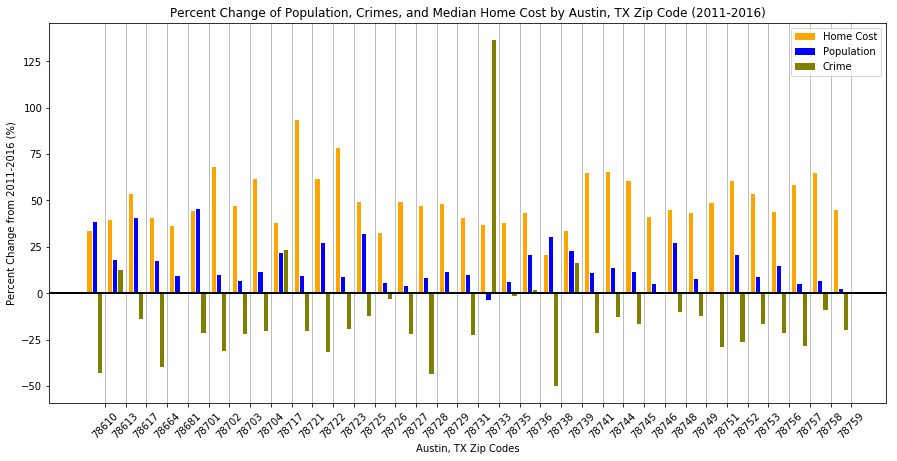

In [12]:
popcrime_df = pd.read_csv('crime_rates.csv')
home_df = pd.read_csv('zillow_data.csv')

hmask_2011 = [x == 2011 for x in home_df.year]
home_df_2011 = home_df[hmask_2011]

hmask_2016 = [x == 2016 for x in home_df.year]
home_df_2016 = home_df[hmask_2016]

merge_years_home = pd.merge(home_df_2011, home_df_2016, on="Zip Code")

merge_years_home['ZHVI_difference'] = merge_years_home['ZHVI_AllHomes_y'] - merge_years_home['ZHVI_AllHomes_x']

merge_years_home['ZHVI_percent_change'] = merge_years_home['ZHVI_difference'] / merge_years_home['ZHVI_AllHomes_x'] * 100

merge_years_home['ZHVI_percent_change'] = merge_years_home['ZHVI_percent_change'].round(2)

pcmask_2011 = [x == 2011 for x in popcrime_df.year]
popcrime_df_2011 = popcrime_df[pcmask_2011]

pcmask_2016 = [x == 2016 for x in popcrime_df.year]
popcrime_df_2016 = popcrime_df[pcmask_2016]

popcrime_df_2011 = popcrime_df_2011.drop(['Crime Rate'], axis=1)

popcrime_df_2016 = popcrime_df_2016.drop(['Crime Rate'], axis=1)

merge_years_popcrime = pd.merge(popcrime_df_2011, popcrime_df_2016, on="Zip Code")

merge_years_popcrime['population_difference'] = merge_years_popcrime['Population_y'] - merge_years_popcrime['Population_x']

merge_years_popcrime['#_of_crimes_difference'] = merge_years_popcrime['Reports_y'] - merge_years_popcrime['Reports_x']

merge_years_popcrime['population_percent_change'] = merge_years_popcrime['population_difference'] / merge_years_popcrime['Population_x'] * 100

merge_years_popcrime['population_percent_change'] = merge_years_popcrime['population_percent_change'].round(2)

merge_years_popcrime['crimes_percent_change'] = merge_years_popcrime['#_of_crimes_difference'] / merge_years_popcrime['Reports_x'] * 100

merge_years_popcrime['crimes_percent_change'] = merge_years_popcrime['crimes_percent_change'].round(2)

merge_years_popcrimecost = pd.merge(merge_years_popcrime, merge_years_home, on="Zip Code")

x_axis_1 = []
counter = 1
for i in range(0,37,1):
    x_axis_1.append(counter)
    counter += 4

x_axis_2 = []
counter = 2
for i in range(0,37,1):
    x_axis_2.append(counter)
    counter += 4

x_axis_3 = []
counter = 3
for i in range(0,37,1):
    x_axis_3.append(counter)
    counter += 4

ticks = []
counter = 4
for i in range(0,37,1):
    ticks.append(counter)
    counter += 4

perc_change_cost = merge_years_popcrimecost['ZHVI_percent_change']
perc_change_pop = merge_years_popcrimecost['population_percent_change']
perc_change_crime = merge_years_popcrimecost['crimes_percent_change']

zip_code_all = merge_years_popcrimecost['Zip Code']

# Create bars
plt.bar(x_axis_1, perc_change_cost, color='orange', alpha=1, label="Home Cost")
plt.bar(x_axis_2, perc_change_pop, color='blue', alpha=1, label="Population")
plt.bar(x_axis_3, perc_change_crime, color='olive', alpha=1, label="Crime")
 
# Create names on the x-axis
plt.xticks(ticks, zip_code_all, rotation=45)
plt.xlabel("Austin, TX Zip Codes")
plt.ylabel("Percent Change from 2011-2016 (%)")
plt.title("Percent Change of Population, Crimes, and Median Home Cost by Austin, TX Zip Code (2011-2016)")
plt.legend()

plt.axhline(0, color='black', linewidth=2)
plt.grid(axis='x')

fig = plt.gcf()
fig.set_size_inches(15,7)

plt.savefig('popcrimecostpercentchangeBARTEST.png')
# Show graphic
plt.show()

Overall, population and median home cost in Austin increased between 2011 and 2016.
There appears to be similarities in the rate of increase for both population and median home cost.
Overall, crime decreased across most of the Austin zip codes.
There is no visibile relationship between the crime and the median home cost

# Types of Crime in 2018

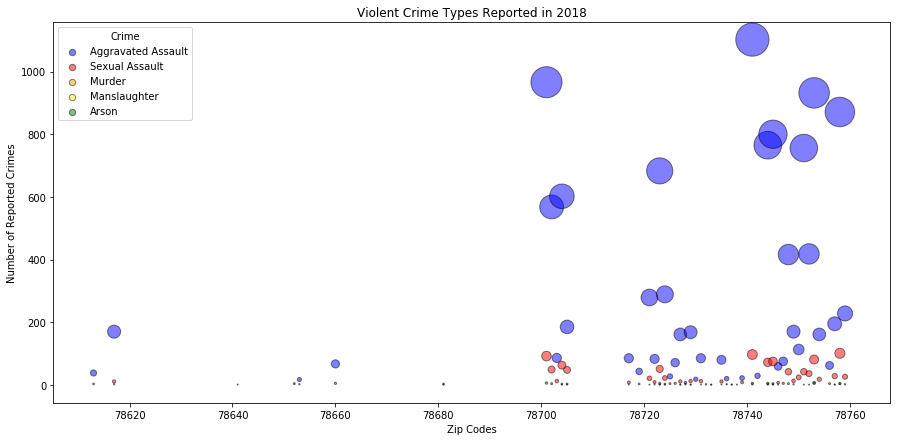

In [13]:
crime2018_df = pd.read_csv('crime_types_2018.csv')

crime_type = crime2018_df.groupby(['Zip Code', 'Highest Offense Description'])['year'].count().to_frame().rename(columns={'year': 'Reports'}).reset_index()

#Start of Variables

#Aggravated Assault
agg_aslt = crime_type[crime_type['Highest Offense Description'] == 'Aggravated Assault']
agg_reports = agg_aslt["Reports"]
agg_aslt_zips = agg_aslt["Zip Code"]

#Theft
theft = crime_type[crime_type['Highest Offense Description'] == 'Theft']
theft_reports = theft["Reports"]
theft_zips = theft["Zip Code"]

#Sexual Assault
sex_assault = crime_type[crime_type['Highest Offense Description'] == 'Sexual Assault']
sex_assault_reports = sex_assault["Reports"]
sex_aslt_zips = sex_assault["Zip Code"]

#Burglary
burglary = crime_type[crime_type['Highest Offense Description'] == 'Burglary']
burglary_reports = burglary["Reports"]
burglary_zips = burglary["Zip Code"]

#Motor Vehicle Theft
mv_theft = crime_type[crime_type['Highest Offense Description'] == 'Motor Vehicle Theft']
mv_theft_reports = mv_theft["Reports"]
mv_theft_zips = mv_theft["Zip Code"]

#Robbery
robbery = crime_type[crime_type['Highest Offense Description'] == 'Robbery']
robbery_reports = robbery["Reports"]
robbery_zips = robbery["Zip Code"]

#Arson
arson = crime_type[crime_type['Highest Offense Description'] == 'Arson']
arson_reports = arson["Reports"]
arson_zips = arson["Zip Code"]

#Murder
murder = crime_type[crime_type['Highest Offense Description'] == 'Murder']
murder_reports = murder["Reports"]
murder_zips = murder["Zip Code"]

#Manslaughter
manslaughter = crime_type[crime_type['Highest Offense Description'] == 'Manslaughter']
manslaughter_reports = manslaughter["Reports"]
manslaughter_zips = manslaughter["Zip Code"]

plt.scatter(agg_aslt_zips, agg_reports, facecolor='blue', edgecolor='black', alpha= 0.5, s=agg_aslt["Reports"], label="Aggravated Assault")
plt.scatter(sex_aslt_zips, sex_assault_reports, facecolor='red', edgecolor='black', alpha= 0.5, s=sex_assault["Reports"], label="Sexual Assault")
plt.scatter(murder_zips, murder_reports, facecolor='orange', edgecolor='black', alpha=0.5, s=murder["Reports"], label="Murder")
plt.scatter(manslaughter_zips, manslaughter_reports, facecolor='yellow', edgecolor='black', alpha=0.5, s=manslaughter["Reports"], label="Manslaughter")
plt.scatter(arson_zips, arson_reports, facecolor='green', edgecolor='black', alpha=0.5, s=arson["Reports"], label="Arson")
plt.xlabel("Zip Codes")
plt.ylabel("Number of Reported Crimes")
plt.title("Violent Crime Types Reported in 2018")
lgnd = plt.legend(title="Crime")
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
lgnd.legendHandles[4]._sizes = [40]
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.savefig("violent_crimes.png")
plt.show()

According to our crime types dataset compilation, violent crime types in the Austin area are broken down into a high-level overview of offenses: Aggravated Assault, Sexual Assault, Murder, and Manslaughter. Aggravated Assault is an umbrella term used by the city to include such reported crimes as assault with a deadly weapon, verbal assault, assault of a minor, among others. Sexual Assault is also an umbrella term, as it encompasses sexual assault by a known contact or family member, sexual assault of a minor, and aggravated sexual assault.

Notice the low number of reports of sexual assault by zip code. In 43 zip codes, only 1140 reports of sexual assault were made in 2018. According to RAINN 25 Years (https://www.rainn.org/statistics/criminal-justice-system), only 230 sexual assaults in 1,000 will be reported nationally. This is number likely comes from the lumping in of all sexual assault cases as well as the likelihood that this is not a fully accurate measure of actual sexual assaults reported, since only the sexual assaults that are reported can be tracked.

In 2018, only 6 reports of manslaughter were made in 6 zip codes, but the occurrence of murder is a little higher. Manslaughter is again a cumulative term, encompassing drunken driving, reckless driving, and criminal negligence, among others. There were 64 instances of arson, but they are spread out, with 21 occurring over the zip codes comprising South East to South West Austin. 6 reports of arson were made in the 78701. In a grand scale of crimes, arson lists fairly low despite being classified as a violent crime.

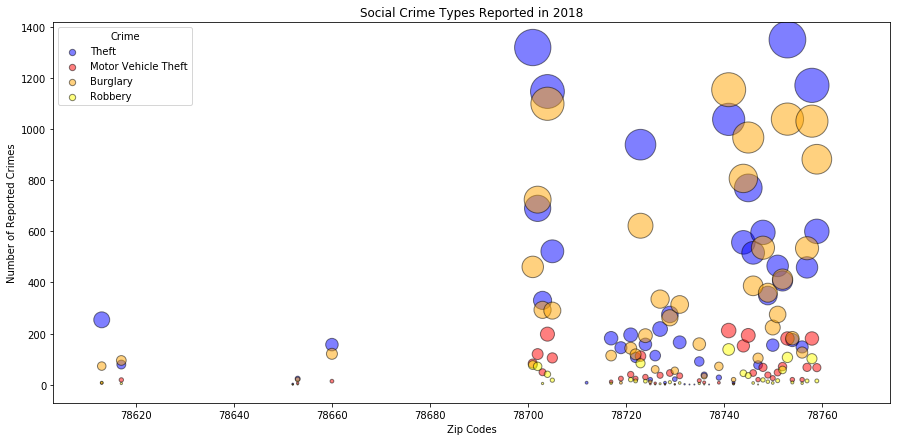

In [14]:
plt.scatter(theft_zips, theft_reports, facecolor='blue', edgecolor='black', alpha= 0.5, s=theft["Reports"], label="Theft")
plt.scatter(mv_theft_zips, mv_theft_reports, facecolor='red', edgecolor='black', alpha= 0.5, s=mv_theft["Reports"], label="Motor Vehicle Theft")
plt.scatter(burglary_zips, burglary_reports, facecolor='orange', edgecolor='black', alpha=0.5, s=burglary["Reports"], label="Burglary")
plt.scatter(robbery_zips, robbery_reports, facecolor='yellow', edgecolor='black', alpha=0.5, s=robbery["Reports"], label="Robbery")
plt.xlabel("Zip Codes")
plt.ylabel("Number of Reported Crimes")
plt.title("Social Crime Types Reported in 2018")
lgnd = plt.legend(title="Crime")
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
fig = plt.gcf()
fig.set_size_inches(15,7)
plt.savefig("nonviolent_crimes.png")
plt.show()

Social crimes have also been boiled down to the major four: Theft, Theft of Motor Vehicle (read as grand theft auto instead of burglary of a vehicle), Burglary, and Robbery. Robbery and Burglary are differentiated, as robbery leans towards an aggravated or violent crime, where burglary is a crime of stealth in which only property is affected.

Notice the trend towards higher reported instances of each crime type that begins at 78700, the literal beginning of the city proper (not the city limits), as the zip codes before that grouping occur further out into the suburbs. For example, 78620 is Dripping Springs. Extrapolated a few zip codes and noted that there are 254 instances theft in 78613, which is Cedar Park, a zip code spanning Williamson County with a population of over 48,000 people. Given that we have calculated a 14% correlation between population size and crime rate, it stands to reason that population density has no real effect on the amount of crime occurring in a given area.

# Population vs Crime

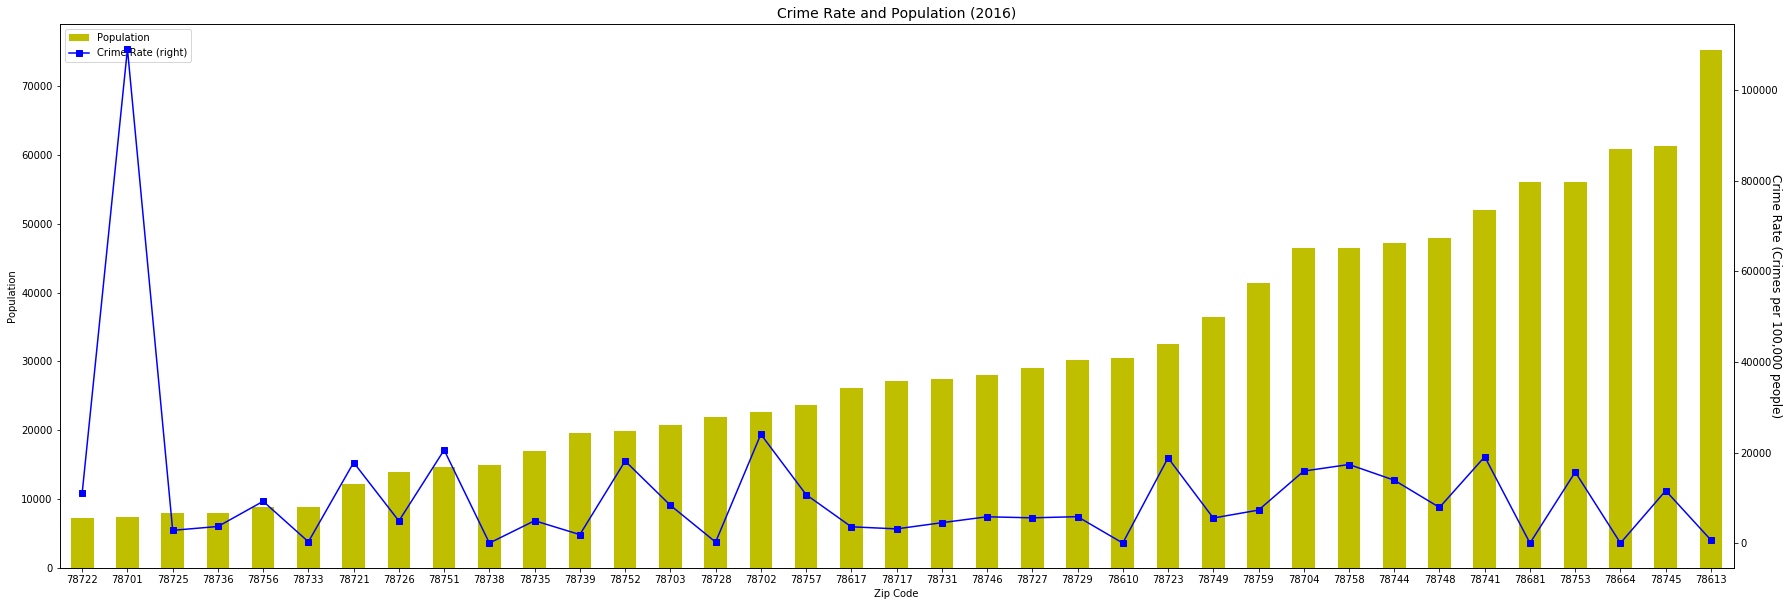

<Figure size 432x288 with 0 Axes>

In [15]:
rates_df = pd.read_csv('crime_rates.csv')

zillow_file = zillow_df.merge(rates_df, on=['year', 'Zip Code'])

zillow_file = zillow_file[zillow_file['year'] == 2016].drop(labels='year', axis=1)

zillow_new = zillow_file

### Apparently this makes all the difference in whether or not the line will show on the bar graph
zillow_new['Zip Code'] = zillow_new['Zip Code'].astype('str')

zillow_new= zillow_new.sort_values('Population', ascending=True).reset_index()

ax1 = zillow_new.plot('Zip Code','Population',kind='bar', color = 'y',figsize=(30, 10))
zillow_new.plot('Zip Code','Crime Rate', kind='line', style='bs-', secondary_y=True, ax=ax1)
ax1.set_ylabel('Population', fontsize=10)
plt.ylabel('Crime Rate (Crimes per 100,000 people)', fontsize=12, rotation=-90)
plt.title("Crime Rate and Population (2016)", fontsize=14)
plt.savefig('crime_rate_and_population.png', bbox_inches='tight')
fig = plt.figure()